# Objetivo do notebook é aplicar os conceitos apresentados no paper "Mean–variance portfolio optimization using machine learning-based", de Wei Chen et. all.

## [Link](https://www.sciencedirect.com/science/article/abs/pii/S1568494620308814 "Artigo")

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import matplotlib.ticker as mtick
import seaborn as sns
import yfinance as yf

style.use('ggplot')

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, GridSearchCV, KFold


In [ ]:
#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [ ]:
#!pip install yfinance
#yf.pdr_override()
#!pip install stldecompose
#add new comment for pr example(delete this if you see it)

In [ ]:

#Lista dos 24 ativos abordados pelo autor, todos parte do índice SSE 50, da Bolsa de Shanghai:

ativos = ['600000.SS', '600018.SS', '600028.SS', '600029.SS', '600031.SS', '600048.SS', '600050.SS', '600089.SS', '600100.SS', '600156.SS', '600547.SS', '600637.SS', '600690.SS', '600837.SS',	'600887.SS', '600999.SS', '601006.SS', '601088.SS', '601111.SS', '601166.SS', '601186.SS', '601688.SS', '601766.SS', '601988.SS']

#O autor avalia os ativos entre novembro/2009 e novembro/2019:
inicio = dt.datetime(2009,11,1)
fim = dt.datetime(2019,11,30)

In [ ]:
#Um teste para avaliar o primeiro dos ativos:
teste = yf.download("600000.SS", start=inicio, end=fim)
teste

In [ ]:
# Baixando os dados e organizando num DF:

df_ativos = pd.DataFrame(columns = teste.columns)

for ativo in ativos:
    
    dados = yf.download(ativo, inicio, fim)
    dados['Ativo'] = ativo 
    df_ativos = pd.concat([df_ativos, dados])
    
    
    print(f"Iniciando o download de {ativo}...")
    

In [ ]:
df_ativos.shape

In [ ]:
df_ativos.head()

In [ ]:
df_ativos

In [ ]:
df_ativos.sort_index(inplace=True) #Organizando o df por datas

In [ ]:
df_ativos.isna().sum() #Nenhum dado nulo...

In [ ]:
#Exemplo do que estamos lidando: Ativo 1:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df_ativos.index,
                      open=df_ativos[df_ativos['Ativo']=='600000.SS'].Open,
                      high=df_ativos[df_ativos['Ativo']=='600000.SS'].High,
                      low=df_ativos[df_ativos['Ativo']=='600000.SS'].Low,
                      close=df_ativos[df_ativos['Ativo']=='600000.SS'].Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_ativos.index, y=df_ativos[df_ativos['Ativo']=='600000.SS'].Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

## Métricas apresentadas pelo autor no artigo:

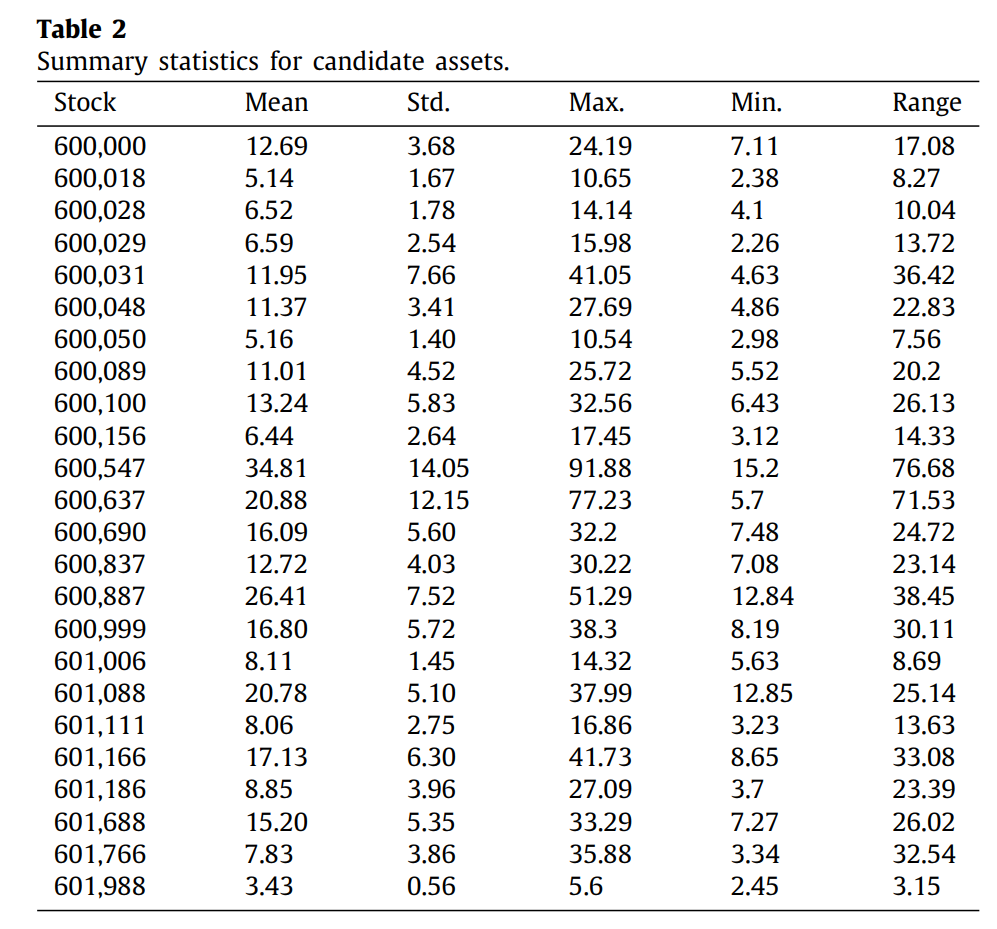

In [ ]:
df_ativos.groupby(['Ativo']).mean() #Médias de preço de fechamento ['Close'] próximos aos que foram obtidos pelo autor, com algumas exceções

In [ ]:
df_ativos.groupby(['Ativo']).count() # -> Nem todos os ativos apresentam cotação para todo o período, porém há dados que cobrem grande parte do espectro temporal para cada ativo.

In [ ]:
#path = r"C:\Users\Alexandre\OneDrive\Documentos\1. PRO\Data Science\Projeto Integrador\Apoio\Abner"
#df_ativos.to_csv(path_or_buf = path+"df_ativos.csv" )

## O paper traz uma série de dados de entrada, que vamos preparar na sequência. São eles:

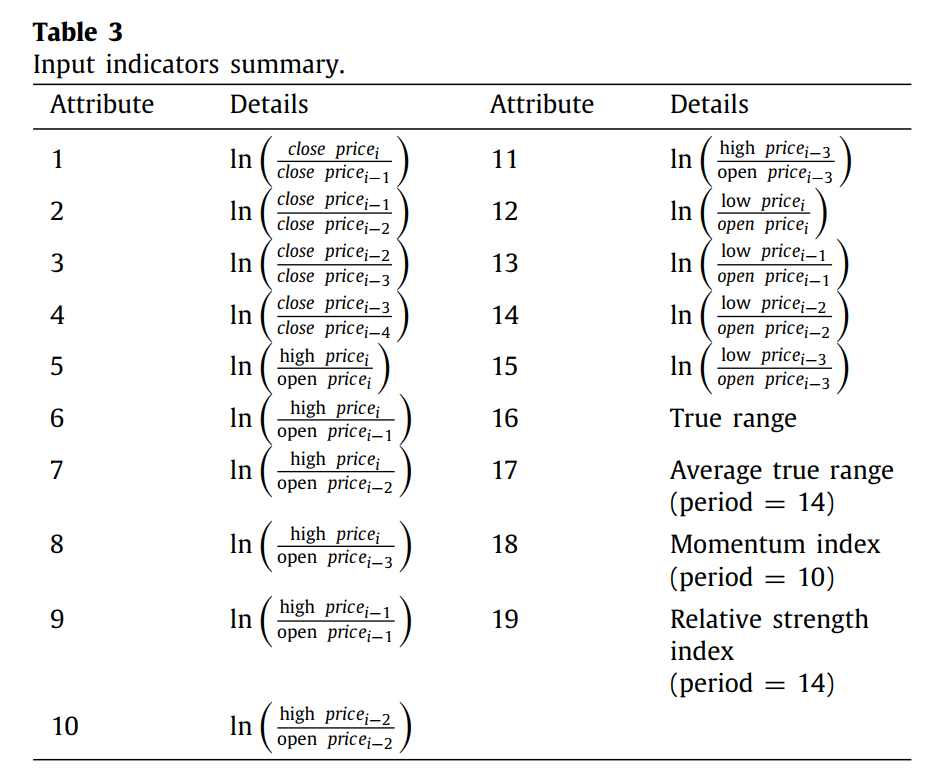

Como se pode observar, são 15 variáveis que envolvem relações temporais entre preços (open, close, high, low), além de 4 outras features muito utilizadas (True Range, Average True Range | 14d, Momentum Index | 10d, Relative Strength Index | 14d).

Na sequência, vamos criar todas essas varíaveis com base nos dados já levantados. Siglas:

* O - Open Price para um dia *"i"* específico
* C - Close Price para um dia *"i"* específico
* H - Highest Price para um dia *"i"* específico
* L - Lowest Price para um dia *"i"* específico



In [ ]:
#Criando as features de entrada no DataFrame:

df_ativos['1: ln(C/C-1)'] = pd.Series(dtype=float)
df_ativos['2: ln(C-1/C-2)'] = pd.Series(dtype=float)
df_ativos['3: ln(C-2/C-3)'] = pd.Series(dtype=float)
df_ativos['4: ln(C-3/C-4)'] = pd.Series(dtype=float)
df_ativos['5: ln(H/O)'] = pd.Series(dtype=float)
df_ativos['6: ln(H/O-1)'] = pd.Series(dtype=float)
df_ativos['7: ln(H/O-2)'] = pd.Series(dtype=float)
df_ativos['8: ln(H/O-3)'] = pd.Series(dtype=float)
df_ativos['9: ln(H-1/O-1)'] = pd.Series(dtype=float)
df_ativos['10: ln(H-2/O-2)'] = pd.Series(dtype=float)
df_ativos['11: ln(H-3/O-3)'] = pd.Series(dtype=float)
df_ativos['12: ln(L/O)'] = pd.Series(dtype=float)
df_ativos['13: ln(L-1/O-1)'] = pd.Series(dtype=float)
df_ativos['14: ln(L-2/O-2)'] = pd.Series(dtype=float)
df_ativos['15: ln(L-3/O-3)'] = pd.Series(dtype=float)
df_ativos['16: True Range'] = pd.Series(dtype=float)
df_ativos['17: ATR 14d'] = pd.Series(dtype=float)
df_ativos['18: MI 10d'] = pd.Series(dtype=float)
df_ativos['19: RSI 14d'] = pd.Series(dtype=float)

In [ ]:
#Calculando as variáveis com logaritmos naturais "lagged":

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'1: ln(C/C-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] / df_ativos.loc[df_ativos['Ativo'] == ativo,'Close'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'2: ln(C-1/C-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'3: ln(C-2/C-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'4: ln(C-3/C-4)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Close'].shift(4))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'5: ln(H/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'6: ln(H/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'7: ln(H/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'8: ln(H/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'9: ln(H-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'10: ln(H-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'11: ln(H-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['High'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'12: ln(L/O)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low']/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'])
    df_ativos.loc[df_ativos['Ativo'] == ativo,'13: ln(L-1/O-1)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(1)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(1))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'14: ln(L-2/O-2)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(2)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(2))
    df_ativos.loc[df_ativos['Ativo'] == ativo,'15: ln(L-3/O-3)'] = np.log(df_ativos.loc[df_ativos['Ativo'] == ativo]['Low'].shift(3)/df_ativos.loc[df_ativos['Ativo'] == ativo]['Open'].shift(3))

Variáveis True Range e Average True Range (Explicadas aqui: https://www.investopedia.com/terms/a/atr.asp#:~:text=The%20true%20range%20indicator%20is,days%2C%20of%20the%20true%20ranges.):

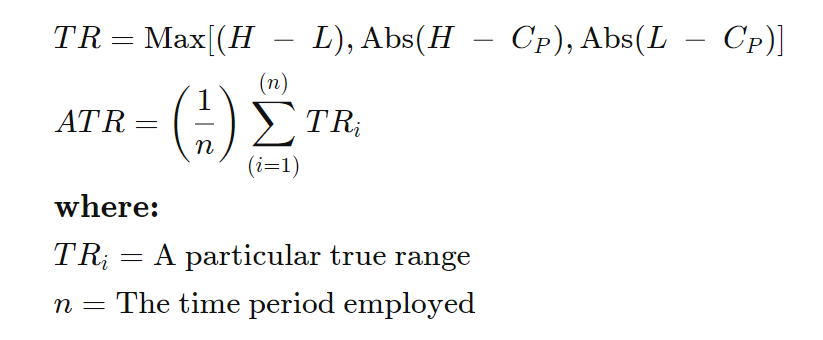



In [ ]:
#Calculando as variáveis True Range e Average True Range | 14d:

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'] = np.nanmax([np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low']), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'High'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1)), 
                                                                            np.abs(df_ativos.loc[df_ativos['Ativo'] == ativo, 'Low'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(1))], axis=0)
    
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'17: ATR 14d'] = df_ativos.loc[df_ativos['Ativo'] == ativo,'16: True Range'].rolling(window=14).mean()
    
    



In [ ]:
#Calculando a variável MSI | 10d (corresponde à diferença de preços entre o dia atual e o décimo dia anterior. Detalhes: https://help.eaglesmarkets.com/hc/en-us/articles/900002105843-What-are-the-MTM-indicators-Detailed-explanation-of-MTM-index):

for ativo in ativos:
    
    df_ativos.loc[df_ativos['Ativo'] == ativo,'18: MI 10d'] = df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'] - df_ativos.loc[df_ativos['Ativo'] == ativo, 'Close'].shift(10)


In [ ]:
#Função para calcular RSI: [Créditos para https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction, levemente modificado para comportar diversos ativos]

def relative_strength_idx(df, ativo, n=14):
    close = df[df['Ativo']==ativo]['Close']
    delta = close.diff()
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100 - (100 / (1 + rs))
    return rsi

for ativo in ativos:

    df_ativos.loc[df_ativos['Ativo'] == ativo,'19: RSI 14d'] = relative_strength_idx(df_ativos,ativo)
    

In [ ]:
#Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close'. 
#Teremos todas as features relacionadas ao mesmo dia, mas a variável de saída será o preço do dia seguinte.

#df_ativos['Close'] = df_ativos['Close'].shift(-1)

In [ ]:
df_ativos

In [ ]:
df_ativos_sna = df_ativos.dropna() #Muitas métricas precisam de mais dias de medição, de forma que os primeiros são nulos. Ao final, partimos do dia 20/11/2009 para a análise. Lembrando que aqui dropamos as ocorrências intrinsecamente ligadas a cada ativo, de forma que um ativo não atrapalha o outro.
df_ativos_sna

In [ ]:
#Dúvida que não quer calar: Usar tudo pra fazer um modelo só (passando OneHotEncoder na feature 'Ativo' e deixando os preços dos ativos se autoinfluenciarem) ou fazer um modelo pra cada ativo?!

In [ ]:
#Um modelo pra cada ativo parece fazer mais sentido... 
#Acho que o melhor caminho seria por um dicionário de DFs, uma entrada pra cada ativo.
#Separando os dataframes para cada Ativo em um dicionário, para  e gerar as features de interesse:

dict_ativos = {}

for ativo in ativos:
    dict_ativos[ativo] = df_ativos_sna[df_ativos_sna['Ativo']==ativo]
    

In [ ]:
dict_ativos

In [ ]:
#Fazendo um split do dataset em 80% treino, 20% teste e armazenando cada um em dicionário específico, já retirando as variáveis não desejadas: 

test_size  = 0.20

dict_train = {}
dict_test = {}

dict_X_train = {}
dict_X_test = {}

dict_y_train = {}
dict_y_test = {}


lista_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume',	'Ativo']

for ativo, df in dict_ativos.items():

    test_split_idx  = int(df.shape[0] * (1-test_size))

#Como a ideia é prever o preço do dia seguinte, vamos dar um shift na coluna 'Close'. 
#Teremos todas as features relacionadas ao mesmo dia, mas a variável de saída será o preço do dia seguinte.
  
    
    df['Close'] = df.loc[:,'Close'].shift(-1) #Gera um NA, então vamos ter que dropar novamente...
    df.dropna(inplace=True)
    
    df_train  = df.iloc[:test_split_idx].copy()
    df_test   = df.iloc[test_split_idx+1:].copy()
    
    X_train = df_train.drop(columns = lista_drop).drop(columns='Close')
    X_test = df_test.drop(columns = lista_drop).drop(columns='Close')
    
    y_train = df_train['Close']
    y_test = df_test['Close']

    dict_train[ativo] = df_train.drop(columns = lista_drop)
    dict_test[ativo] = df_test.drop(columns = lista_drop)
    
    dict_X_train[ativo] = X_train
    dict_X_test[ativo] = X_test
    
    dict_y_train[ativo] = y_train
    dict_y_test[ativo] = y_test

In [ ]:
df_train

In [ ]:
#Acessando, por exemplo, o df_train do primeiro ativo:
list(dict_train.values())[0]

In [ ]:
list(dict_train.values())[0]

In [ ]:
#Vamos ver a cara dessa bagaça e como ficaram temporalmente treino, validação e teste...
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(dict_train.values())[0].index, y=list(dict_train.values())[0].Close, name='Treino'))
fig.add_trace(go.Scatter(x=list(dict_test.values())[0].index,  y=list(dict_test.values())[0].Close,  name='Teste'))
fig.show()

In [ ]:
#Ok, parece que temos tudo para começar a modelagem. Vamos ao que interessa...

In [ ]:
#!pip install xgboost

In [ ]:
import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
#Vamos checar as variáveis de entrada para o primeiro ativo
list(dict_X_train.values())[0].info()

In [ ]:
param = {
    'n_estimators': [50, 100, 200, 300, 400, 500], #Quanto maior, ficou melhor. -> Mudar o intervalo pra cima...
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1], #Quanto maior, ficou melhor -> Mudar o intervalo pra cima...
    'max_depth': [3, 4, 5, 7, 10], #Quanto menor, ficou melhor -> Mudar o intervalo pra baixo...
    'gamma': [0.001, 0.003, 0.005, 0.007, 0.01], #No meio ficou melhor. Testar variações menores a partir do 0.005
    'random_state': [248]
}

#eval_set = [(list(dict_X_train.values())[0], (list(dict_y_train.values())[0])), (list(dict_X_valid.values())[0], (list(dict_y_valid.values())[0]))]
#eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric = 'rmse')

k = 10

kf = KFold(n_splits=k, shuffle = True, random_state = 248)

grid_s = GridSearchCV(model, param, cv=kf.split(list(dict_X_train.values())[0], list(dict_y_train.values())[0]) )

grid_s.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])

print(f'Best params: {grid_s.best_params_}')
print(f'Best validation score = {grid_s.best_score_}')

In [ ]:
#Setando o melhor modelo:

model = xgb.XGBRegressor(**grid_s.best_params_, objective='reg:squarederror', eval_metric = 'rmse')
model.fit(list(dict_X_train.values())[0], list(dict_y_train.values())[0])

In [ ]:
#Olhando Feature Importance:
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(model, height = 0.5)

In [ ]:
#Verificando performance do modelo para o conjunto de testes desse primeiro ativo:

y_pred_train = model.predict(list(dict_X_train.values())[0])
y_pred_test = model.predict(list(dict_X_test.values())[0])

print(f'Treino: mean_squared_error = {mean_squared_error(list(dict_y_train.values())[0], y_pred_train)}')
print(f'Teste: mean_squared_error = {mean_squared_error(list(dict_y_test.values())[0], y_pred_test)}')

In [ ]:
#Visualização para este único ativo:

pred_close_train = list(dict_train.values())[0].copy()
pred_close_test = list(dict_test.values())[0].copy()
pred_close = pd.concat([pred_close_train, pred_close_test ])

plt.rcParams["figure.figsize"] = (100, 20)
fig = make_subplots(rows=3, cols=1, )

fig.add_trace(go.Scatter(x=pred_close_train.index, y=list(dict_train.values())[0]['Close'],
                         name='Real - Treino',
                         marker_color='Green'), row=1, col=1)

fig.add_trace(go.Scatter(x=pred_close_train.index,
                         y=y_pred_train,
                         name='Predição - Treino',
                         marker_color='DarkBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=pred_close_test.index, y=list(dict_test.values())[0]['Close'],
                         name='Real - Teste',
                         marker_color='Green'), row=3, col=1)

fig.add_trace(go.Scatter(x=pred_close_test.index,
                         y=y_pred_test,
                         name='Predição - Teste',
                         marker_color='DarkBlue'), row=3, col=1)

fig.show()

## O Artigo trouxe as seguintes métricas, comparando o seu modelo aos outros testados:

<div>
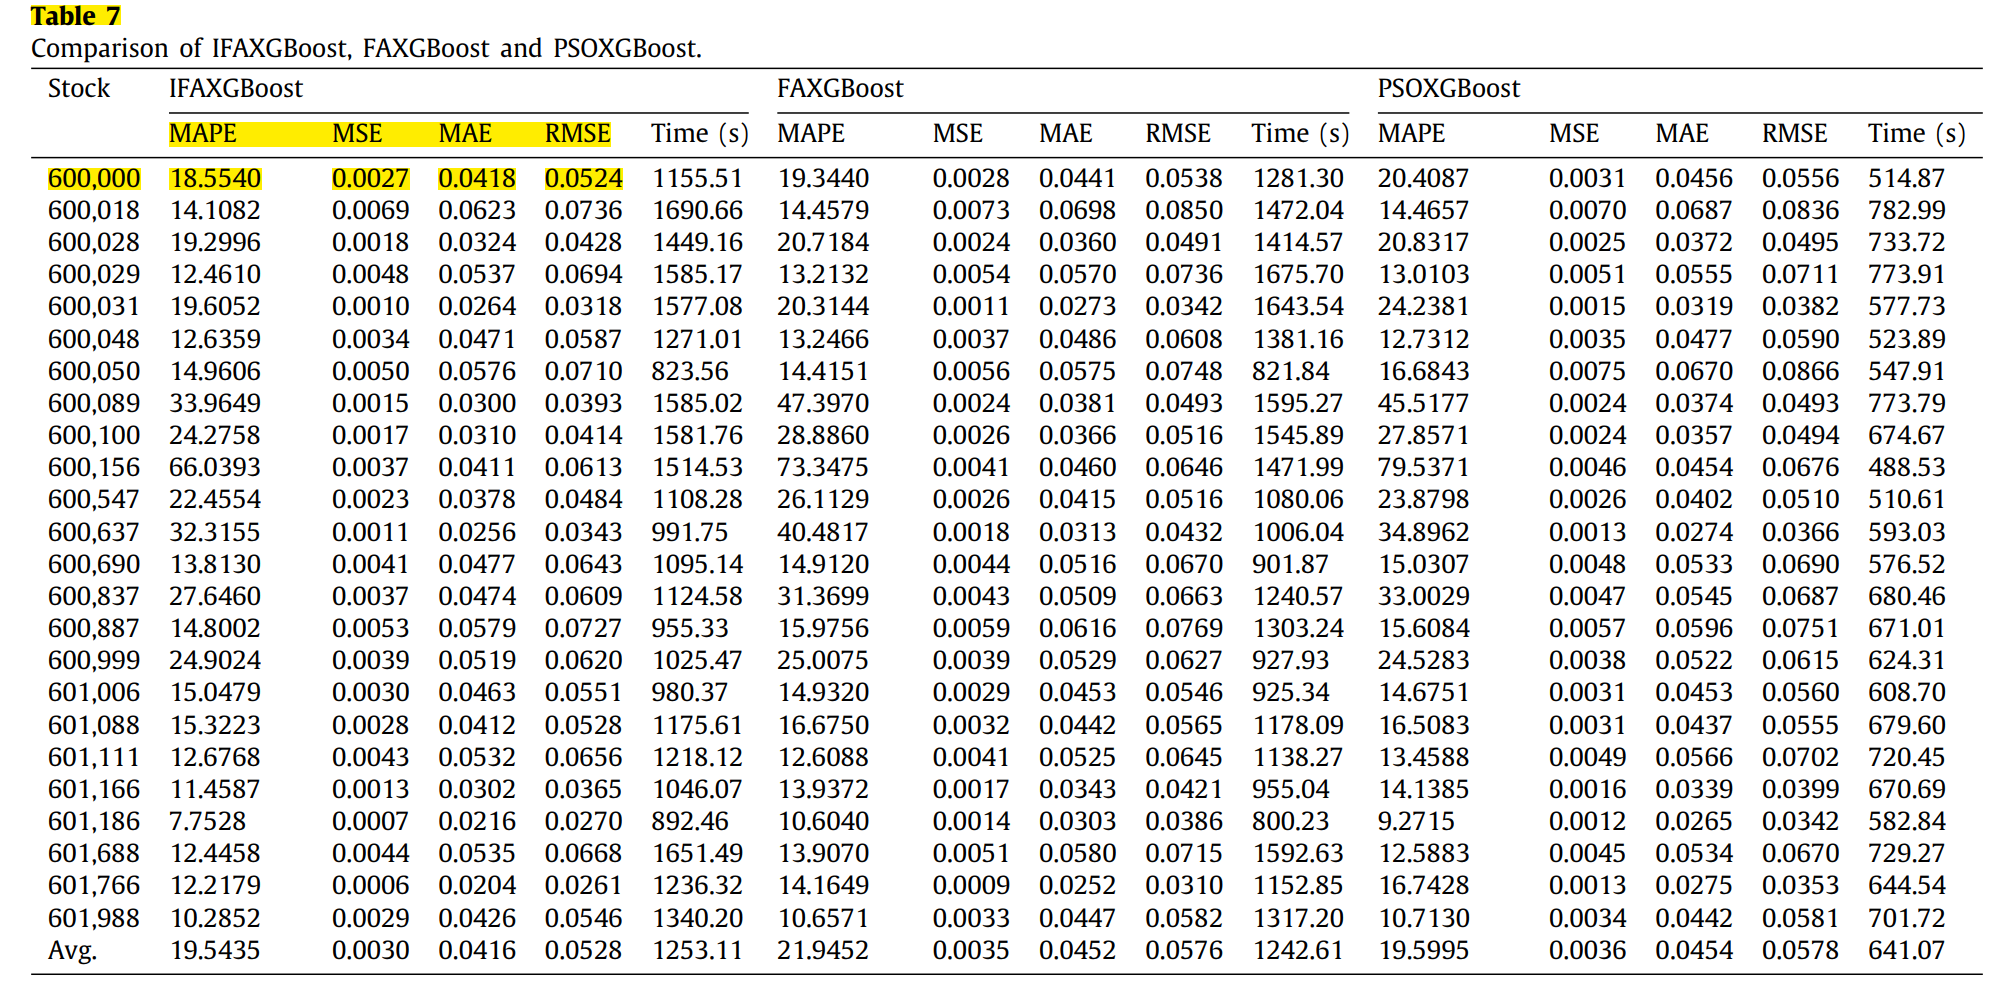
</div>


In [ ]:
#Comparando MAPE, MSE, MAE e RMSE obtidos para o primeiro ativo com os do modelo do paper:

#from sklearn.metrics import mean_absolute_percentage_error -> Dando erro
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#MAPE = mean_absolute_percentage_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test) -> Fazer na mão grande
MAPE_test = np.mean(np.abs((list(dict_test.values())[0]['Close'] - y_pred_test)/list(dict_test.values())[0]['Close']))
MSE_test = mean_squared_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test, squared = False)
MAE_test = mean_absolute_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test)
RMSE_test = mean_squared_error(y_true = list(dict_test.values())[0]['Close'], y_pred = y_pred_test, squared = True)

print("Performance prevendo o Ativo 600.000 (Teste):")
print(f'MAPE = {MAPE_test:.4f}')
print(f'MSE = {MSE_test:.4f}')
print(f'MAE = {MAE_test:.4f}')
print(f'RMSE = {RMSE_test:.4f}')

In [ ]:
#Checando as mesmas métricas no treino:

MAPE_train = np.mean(np.abs((list(dict_train.values())[0]['Close'] - y_pred_train)/list(dict_train.values())[0]['Close']))
MSE_train = mean_squared_error(y_true = list(dict_train.values())[0]['Close'], y_pred = y_pred_train, squared = False)
MAE_train = mean_absolute_error(y_true = list(dict_train.values())[0]['Close'], y_pred = y_pred_train)
RMSE_train = mean_squared_error(y_true = list(dict_train.values())[0]['Close'], y_pred = y_pred_train, squared = True)

print("Performance no treino com o Ativo 600.000:")
print(f'MAPE = {MAPE_train:.4f}')
print(f'MSE = {MSE_train:.4f}')
print(f'MAE = {MAE_train:.4f}')
print(f'RMSE = {RMSE_train:.4f}')

In [ ]:
#Melhorar o tunning com base nos melhores parâmetros obtidos.

### Referência interessante em: https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction
### Biblioteca de params XGBoost: https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#parameters-for-tree-booster
### GridSearch com crossval (atenção que é clf, não reg): https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

## Próximos passos: 
* Checar as métricas obtidas com as do paper (MSE, pelo menos);
* Entender com Abner o melhor approach para fitar os modelos para cada ativo (dicionário funciona, mas talvez seja mais simples) ;
* Melhorar o tunning do modelo -> Tentar implementar o IFA?
* Implementar a seleção de portfólio -> Mean-Variance;
* Testar com as cryptos e fazer o tunning novamente;
* Deploy!
